In [1]:
from PIL import Image
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

import numpy as np
import cv2
import os
from os import listdir

import math
import imageio
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib import image

%matplotlib inline

from glob import glob 
import re

import xml.etree.ElementTree as ET
import shutil

import random

In [2]:
data_dir="data"

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    
card_dir = "data/cards"

if not os.path.isdir(card_dir):
    os.makedirs(img_dir)

cards = []
for c in listdir(card_dir):
    img = image.imread(card_dir +'/' + c,1)
    cards.append(img)


In [29]:
card_suits=['s','h','d','c']
card_values=['A','2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
mmToPixel = 3.7795

#Card dimensions in mm
cardW=63
cardH=88
card_corners = [0, cardW, 0, cardH]

rank_x1 = 1
rank_x2 = 27
rank_y1 = 1
rank_y2 = 45
rank_vals = [rank_x1, rank_x2, rank_y1, rank_y2]

suit_x1= 27
suit_x2= 47
suit_y1= 8
suit_y2= 35
suit_vals = [suit_x1, suit_x2, suit_y1, suit_y2]

#Scale to pixels
zoom=1
cardW*=zoom
cardH*=zoom

rank_vals = [int(i*zoom*mmToPixel) for i in rank_vals]
suit_vals = [int(i*zoom*mmToPixel) for i in suit_vals]
card_corners = [int(i*zoom*mmToPixel) for i in card_corners]

pixelW = math.ceil(cardW * mmToPixel)
pixelH = math.ceil(cardH * mmToPixel)

cards = [ia.imresize_single_image(i, (card_corners[3], card_corners[1])) for i in cards]



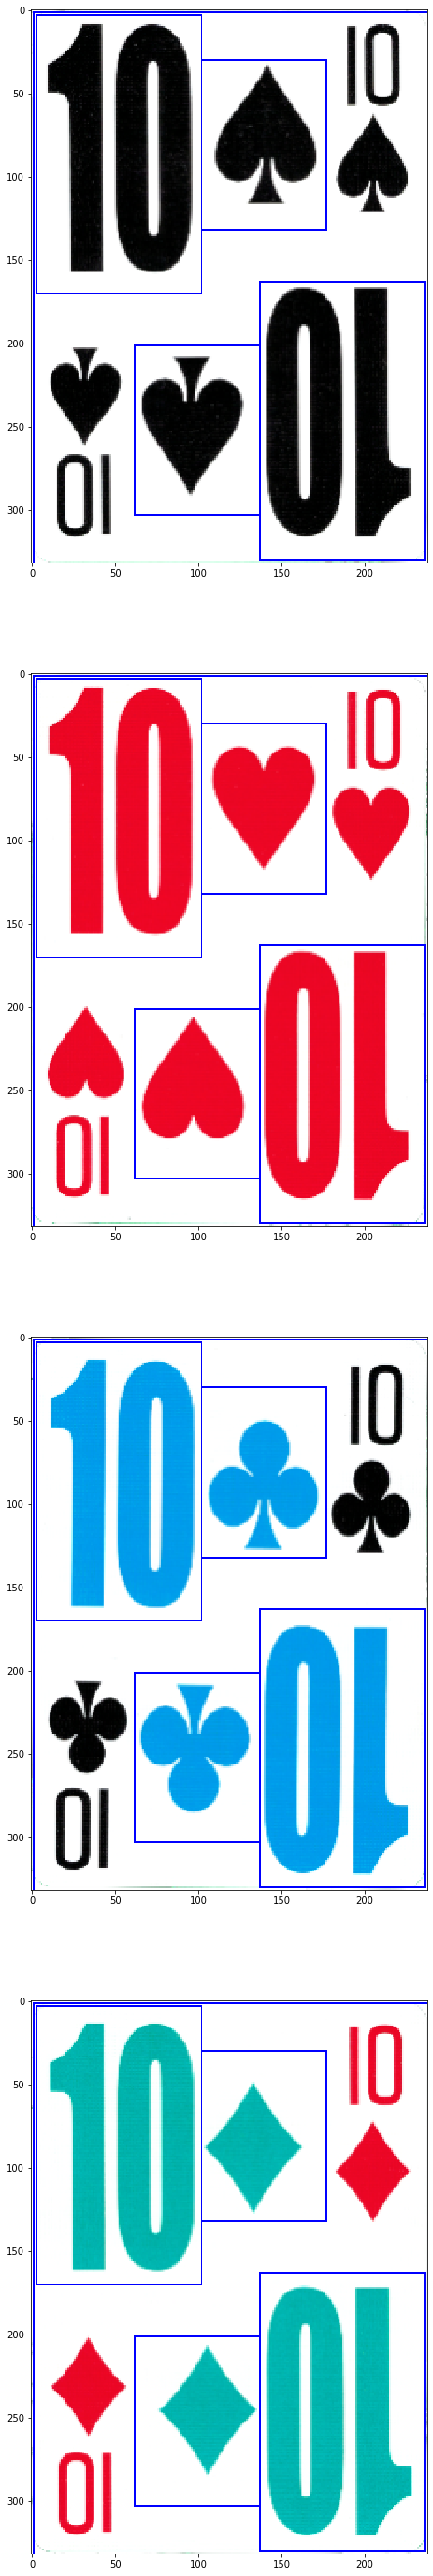

In [30]:
x=0
y = 0

bounding_boxes = [#Card borders
                  BoundingBox(x1=1, x2=pixelW, 
                              y1=1, y2=pixelH),
                  BoundingBox(x1=1, x2=pixelW, 
                              y1=1, y2=pixelH),
                  #Rank borders
                  BoundingBox(x1=rank_vals[0]+x, x2=rank_vals[1]+x, 
                              y1=rank_vals[2]+y, y2=rank_vals[3]+y),
                  BoundingBox(x1=pixelW-rank_vals[0]+x, x2=pixelW-rank_vals[1]+x, 
                              y1=pixelH-rank_vals[2]+y, y2=pixelH-rank_vals[3]+y),
                  #Suit borders
                  BoundingBox(x1=suit_vals[0]+x, x2=suit_vals[1]+x, 
                              y1=suit_vals[2]+y, y2=suit_vals[3]+y),
                  BoundingBox(x1=pixelW-suit_vals[0]+x, x2=pixelW-suit_vals[1]+x, 
                              y1=pixelH-suit_vals[2]+y, y2=pixelH-suit_vals[3]+y)]

bbs = BoundingBoxesOnImage(bounding_boxes, shape=img.shape)
f = plt.figure(figsize=(50,50))
for i in range(len(cards)):
    img = bbs.draw_on_image(cards[i], size=1, color=[0, 0, 255,255]) 
    f.add_subplot(4,1,i+1)
    plt.imshow(img)
    if i == 3:
        break
plt.show()


In [ ]:
#Grab background and resize background
backgrounds = []
background_dir = "data/dtd/images"
backgroundW = 800

c = 0
for subfolder in listdir(background_dir):
    for b in listdir(background_dir+"/"+subfolder):
        img = image.imread(background_dir + '/' + subfolder + '/' + b)
        img = ia.imresize_single_image(img, (backgroundW, backgroundW))
        backgrounds.append(img)
        c+=1
        if c == 2:
            break
    if c==2:
        break
_=plt.imshow(backgrounds[0])            
        
            

In [ ]:
#Convert white space to transparent background on cards
for i in range(len(cards)):
    cards[i] = Image.fromarray(cards[i])
    cards[i] = cards[i].convert("RGBA")
    pixelMap = cards[i].load()
    w,h = cards[i].size
    for y in range(h):
        for x in range(w):
            if pixelMap[x, y] == (255, 255, 255, 255):
                pixelMap[x, y] = (255, 255, 255, 0)
    cards[i] = np.asarray(cards[i])


In [ ]:
#Returns area of overlap
#Box[xmin,xmax,ymin,ymax]
def overlap(box1, box2):
    print("SDF")
    if box1[0] <= box2[1]  and box2[1] <= box1[0] and box1[2] <= box2[3] and box2[2] <= box1[3]:
        print("FUNC FOUND")
        return (box1[1] - box2[0]) * (box1[2] - box2[3])
    return 0
    

In [ ]:
#Randomly pick two cards 
a = random.randint(0, len(cards)-1)
b = random.randint(0, len(cards)-1)

#Paste cards onto background
background = Image.fromarray(backgrounds[0])
x = random.randint(0,backgroundW-pixelW)
y = random.randint(0,backgroundW-pixelH)
card = Image.fromarray(cards[a])
background.paste(card, (x,y), card)


xx = random.randint(0,backgroundW-pixelW)
yy = random.randint(0,backgroundW-pixelH)
xx = x
yy = y
card = Image.fromarray(cards[b])
background.paste(card, (xx,yy), card)

#CHECK IF SUIT AND NUMBER OF BOTTOM CARD IS COMPLETELY COVERED
#REMOVE BOUNDING BOX IF IT IS

bounding_boxes = [#Card borders
                  BoundingBox(x1=x, x2=pixelW + x, 
                              y1=y, y2=pixelH + y),
                  BoundingBox(x1=xx, x2=pixelW + xx, 
                              y1=yy, y2=pixelH + yy),
                  #Rank borders
                  BoundingBox(x1=rank_vals[0]+xx, x2=rank_vals[1]+xx, 
                              y1=rank_vals[2]+yy, y2=rank_vals[3]+yy),
                  BoundingBox(x1=pixelW-rank_vals[0]+xx, x2=pixelW-rank_vals[1]+xx, 
                              y1=pixelH-rank_vals[2]+yy, y2=pixelH-rank_vals[3]+yy),
                  #Suit borders
                  BoundingBox(x1=suit_vals[0]+xx, x2=suit_vals[1]+xx, 
                              y1=suit_vals[2]+yy, y2=suit_vals[3]+yy),
                  BoundingBox(x1=pixelW-suit_vals[0]+xx, x2=pixelW-suit_vals[1]+xx, 
                              y1=pixelH-suit_vals[2]+yy, y2=pixelH-suit_vals[3]+yy)]

# #Check if there is overlap first
box1 = [x + suit_vals[i] for i in range(2)] + [y + suit_vals[i] for i in range(2,4)]
box2 = [xx + card_corners[i] for i in range(2)] + [yy + card_corners[i] for i in range(2,4)]

print(box1)
print(bbs[0])
print(x, y, x + pix)
overlapping_area = overlap(box1, box2)
print(overlapping_area)
bb_area = (suit_vals[1] - suit_vals[0]) * (suit_vals[3] - suit_vals[2]) 
cover_limit = 0.85

if (bb_area - overlapping_area) / bb_area < cover_limit:
    print("OVERLAPPING")
    bounding_boxes.insert(0,BoundingBox(x1=suit_vals[0]+x, x2=suit_vals[1]+x, y1=suit_vals[2]+y, y2=suit_vals[3]+y))

#Bound boxes
bbs = BoundingBoxesOnImage(bounding_boxes, shape=img.shape)

background = bbs.draw_on_image(background, size=3,color=[0, 0, 255])


plt.figure(figsize=(10,10))
plt.imshow(background) # display the image
plt.show()



In [ ]:
#Randomly augment images

background = np.asarray(background)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-16, 16)
    )
], random_order=True) # apply augmenters in random order

images_aug,bbs_aug = seq(image=background,bounding_boxes=bbs)
plt.figure(figsize=(10,10))
plt.imshow(images_aug) # display the image
plt.show()

In [ ]:
GREEN = [0, 255, 0,255]
ORANGE = [255, 140, 0,255]
RED = [255, 0, 0,255]

# Pad image with a 1px white and (BY-1)px black border
def pad(image, by):
    image_border1 = ia.pad(image, top=1, right=1, bottom=1, left=1,
                           mode="constant", cval=255)
    image_border2 = ia.pad(image_border1, top=by-1, right=by-1,
                           bottom=by-1, left=by-1,
                           mode="constant", cval=0)
    return image_border2

# Draw BBs on an image
# and before doing that, extend the image plane by BORDER pixels.
# Mark BBs inside the image plane with green color, those partially inside
# with orange and those fully outside with red.
def draw_bbs(image, bbs, border):
    image_border = pad(image, border)
    for bb in bbs.bounding_boxes:
        if bb.is_fully_within_image(image.shape):
            color = GREEN
        elif bb.is_partly_within_image(image.shape):
            color = ORANGE
        else:
            color = RED
        image_border = bb.shift(left=border, top=border)\
                         .draw_on_image(image_border, size=2, color=color)

    return image_border
padded = draw_bbs(images_aug,bbs_aug.remove_out_of_image().clip_out_of_image(),50)
plt.figure(figsize=(10,10))
plt.imshow(padded) # display the image
plt.show()

In [ ]:
import random
#Augment cards and bounding boxes
x = random.randint(5,200)
y = random.randint(5,200)
seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        translate_px={"x": x, "y": y},
        scale=(0.5, 0.7)
    ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])

image_aug, bbs_aug = seq(image=image_before, bounding_boxes=bbs)

# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )

image_after = bbs_aug.draw_on_image(image_aug, size=2, color=[0, 0, 255])

plt.figure(figsize=(10,10))
plt.imshow(image_before) # display the image
plt.figure(figsize=(10,10))
plt.imshow(image_after) # display the image


In [ ]:
image = background
image_rescaled = ia.imresize_single_image(image, (512, 512))
bbs_rescaled = bbs.on(image_rescaled)

# Draw image before/after rescaling and with rescaled bounding boxes
image_bbs = bbs.draw_on_image(image, size=2)
image_rescaled_bbs = bbs_rescaled.draw_on_image(image_rescaled, size=2)

In [ ]:
xml_object=""" <object>
                <name>{CLASS}</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>{XMIN}</xmin>
                        <ymin>{YMIN}</ymin>
                        <xmax>{XMAX}</xmax>
                        <ymax>{YMAX}</ymax>
                </bndbox>
        </object>
"""